In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pickle
import time
import os.path
import math
from xgboost import XGBClassifier
from sklearn.externals import joblib
import pandas as pd

n_bytes = 2**31
max_bytes = 2**31 - 1

class Time_Tracking():
    
    start_time = None
    
    def start_tracking(self):
        
        self.start_time = time.time()
    
    def stop_tracking(self):
        
        print("Time used:", round(((time.time() - self.start_time)/60),2), ' minutes')


def load_pickle(file_path):
    
    bytes_in = bytearray(0)
    input_size = os.path.getsize(file_path)
    with open(file_path, 'rb') as f_in:
        for _ in range(0, input_size, max_bytes):
            bytes_in += f_in.read(max_bytes)
    
    return pickle.loads(bytes_in)

In [2]:
model = joblib.load("xgb.pickle.dat")

train = load_pickle('train_df_after_preprocessing.pkl')
valid = load_pickle('valid_df_after_preprocessing.pkl')
test = load_pickle('test_df_after_preprocessing.pkl')

valid_click = valid['click']
valid_bidprice = valid['bidprice']
valid_payprice = valid['payprice']
valid_X = valid.drop(['click', 'bidprice', 'payprice'], axis = 1)

In [3]:
valid_ctr_prediction = model.predict_proba(valid_X)

# Threshold sigmoid bidding: 1/( 1+exp^(-z) )

In [4]:
def EvaluateClick( bid_price, budget, valid_payprice, valid_click):
    
    auction = bid_price >= valid_payprice
    win_bid_ix = [ index for index,auc in enumerate(auction) if auc ]
    bid_spends = valid_payprice[win_bid_ix].values
    bid_clicks = valid_click[win_bid_ix].values

    budget = 6250000
    current_spend = sum(bid_spends)

    total_bids = len(bid_spends)

    for i in range(len(bid_spends)):

        current_spend -= bid_spends[total_bids-i-1]

        if current_spend <= budget:
            break

    final_win_bid_ix = win_bid_ix[:(total_bids - i -1)]
    bid_spends = sum(valid_payprice[final_win_bid_ix].values)
    bid_clicks = sum(valid_click[final_win_bid_ix].values)
    
    print('clicks:', bid_clicks, 'impressions:', len(final_win_bid_ix), 'spend:', bid_spends)

    return bid_clicks

clicks: 98 impressions: 152895 spend: 5389721
clicks: 98 impressions: 153920 spend: 5459495
clicks: 99 impressions: 154916 spend: 5526917
clicks: 99 impressions: 155952 spend: 5597472
clicks: 101 impressions: 156778 spend: 5653140
clicks: 101 impressions: 157911 spend: 5731640
clicks: 103 impressions: 158738 spend: 5788684
clicks: 104 impressions: 159803 spend: 5863471
clicks: 106 impressions: 160704 spend: 5926612
clicks: 106 impressions: 161687 spend: 5995614
clicks: 106 impressions: 162626 spend: 6061900
clicks: 106 impressions: 163599 spend: 6129973
clicks: 106 impressions: 164627 spend: 6202658
clicks: 105 impressions: 164941 spend: 6249954
clicks: 103 impressions: 164080 spend: 6249986
clicks: 102 impressions: 163209 spend: 6249982
clicks: 103 impressions: 162472 spend: 6249994
clicks: 97 impressions: 161645 spend: 6249997
clicks: 97 impressions: 160623 spend: 6249959
clicks: 96 impressions: 159368 spend: 6249970
best constant: 178


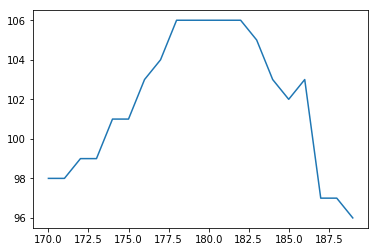

In [8]:
sigmoid = [ 1/( 1 + math.exp(-(z-0.8))) for z in valid_ctr_prediction[:,1] ]

base_prices =  np.arange(170,190,1)
spend = []
clicks = []
budget = 6250000

for base in base_prices:
    
    bid_price = [base*s for s in sigmoid]
    c = EvaluateClick( bid_price, budget , valid_payprice, valid_click)
    clicks.append(c)

plt.figure()
plt.plot(base_prices, clicks)
print('best constant:', base_prices[clicks.index(max(clicks))])

In [9]:
base = 178

sigmoid = [ 1/( 1 + math.exp(-(z-0.8))) for z in valid_ctr_prediction[:,1] ]
bid_price = [base*s for s in sigmoid]
EvaluateClick( bid_price, budget , valid_payprice, valid_click)

clicks: 106 impressions: 160704 spend: 5926612


106

In [10]:
### prediction
base = 178

test_prediction = model.predict_proba(test)[:,1]
sigmoid = [ 1/( 1 + math.exp(-(z-0.8))) for z in test_prediction ]
bid_price = [base*s for s in sigmoid]

submission = pd.read_csv('Group_xx.csv')
submission['bidprice'] = bid_price
submission.to_csv('XGB_with_SigmoidThreshold.csv')